Python 3
Tensorflow CPU version
 

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
try:
    %tensorflow_version 2.x
except:
    pass
# import tensorflow.compat.v1 as tf
# tf.disable_v2_behavior()
import tensorflow as tf
import tensorflow.keras.backend as K
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import matplotlib.image as mpimg 
import keras
from tensorflow.keras import Model
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, UpSampling2D, LeakyReLU, Concatenate, BatchNormalization, MaxPool2D
from tensorflow.keras.applications import DenseNet169, DenseNet121, densenet
from keras.callbacks import LearningRateScheduler, ModelCheckpoint
import os
import glob
from shutil import copy
import cv2
from time import strftime, localtime
os.chdir('/content/drive/My Drive/ZSSR-master/')

Using TensorFlow backend.


# Config

In [0]:
# scaling factor
SR_FACTOR = 2
# Activation layer
ACTIVATION = 'relu'
# Data generator random ordered
SHUFFLE = False
# scaling factors array order random or sorted
SORT = True
# Ascending or Descending: 'A' or 'D'
SORT_ORDER = 'A'
# number of time steps (pairs) per epoch
NB_STEPS = 1
# kernel size
KERNEL_SIZE = 3
# Batch size
BATCH_SIZE = 1
# Number of channels in signal
NB_CHANNELS = 3
# No. of NN filters per layer
FILTERS = 64  # 64 on the paper
# Number of internal convolutional layers
LAYERS_NUM = 6
# No. of scaling steps. 6 is best value from paper.
NB_SCALING_STEPS = 1
# No. of LR_HR pairs
EPOCHS = NB_PAIRS = 1500
# Default crop size (in the paper: 128*128*3)
CROP_SIZE = [96]#[32,64,96,128]
# Momentum # default is 0.9 # 0.86 seems to give lowest loss *tested from 0.85-0.95
BETA1 = 0.90  # 0.86
# Adaptive learning rate
INITIAL_LRATE = 0.001
DROP = 0.5
# Adaptive lrate, Number of learning rate steps (as in paper)
FIVE = 5
# Decide if learning rate should drop in cyclic periods.
LEARNING_RATE_CYCLES = False
#
# EPOCHS_DROP = np.ceil((NB_STEPS * EPOCHS ) / NB_SCALING_STEPS)
# Plot super resolution image when using zssr.predict
PLOT_FLAG = False
# Crop image for training
CROP_FLAG = True
# Flip flag
FLIP_FLAG = True
# initial scaling bias (org to fathers)
SCALING_BIAS = 1
# Scaling factors - blurring parameters
BLUR_LOW = 0.4
BLUR_HIGH = 0.95
# Add noise or not to transformations
NOISE_FLAG = False
# Mean pixel noise added to lr sons
NOISY_PIXELS_STD = 30
# Save augmentations
SAVE_AUG = True
# If there's a ground truth image. Add to parse.
GROUND_TRUTH = True
# If there's a baseline image. Add to parse.
BASELINE = True
# png compression ratio: best quality
CV_IMWRITE_PNG_COMPRESSION = 9

ORIGIN_IMAGE = 0
GROUND_TRUTH_IMAGE = 1
BASELINE_IMAGE = 2

# We're making sure These parameters are equal, in case of an update from the parser.
NB_PAIRS = EPOCHS
EPOCHS_DROP = np.ceil((NB_STEPS * EPOCHS) / NB_SCALING_STEPS)
    

In [0]:
def plot_image(image):
  plt.figure()
  plt.imshow(image)
  plt.show()


def predict_func(image):
    # Resize original image to super res size
    image = image.astype(np.float32)
    interpolated_image = cv2.resize(image, None, fx=SR_FACTOR, fy=SR_FACTOR, interpolation=cv2.INTER_CUBIC)  # SR_FACTOR
    # Expand dims for NN
    interpolated_image = np.expand_dims(interpolated_image, axis=0)

    # Expand dims for NN
    # Check if image is a 4D tensor
    if len(np.shape(interpolated_image)) == 4:
        pass
    else:
        interpolated_image = np.expand_dims(interpolated_image, axis=0)

    # Get prediction from NN
    super_image = zssr.predict(interpolated_image)
    # Reduce the unwanted dimension and get image from tensor
    super_image = np.squeeze(super_image, axis=(0))
    interpolated_image = np.squeeze(interpolated_image, axis=(0))

    # Normalize data type back to uint8
    super_image = cv2.convertScaleAbs(super_image)
    interpolated_image = cv2.convertScaleAbs(interpolated_image)

    # Save super res image
    cv2.imwrite(result_path + '/' + str(SR_FACTOR) + '_super.png', cv2.cvtColor(super_image, cv2.COLOR_RGB2BGR),
                params=[CV_IMWRITE_PNG_COMPRESSION])
    # Save bi-cubic enlarged image
    cv2.imwrite(result_path + '/' + str(SR_FACTOR) + '_super_size_interpolated.png',
                cv2.cvtColor(interpolated_image, cv2.COLOR_RGB2BGR), params=[CV_IMWRITE_PNG_COMPRESSION])

    return super_image, interpolated_image

def accumulated_result(image):
    # Resize original image to super res size
    int_image = cv2.resize(image, None, fx=SR_FACTOR, fy=SR_FACTOR, interpolation=cv2.INTER_CUBIC)  # SR_FACTOR
    print("NN Input shape:", np.shape(int_image))
    super_image_accumulated = np.zeros(np.shape(int_image))
    # Get super res image from the NN's output
    super_image_list = []
    for k in range(0, 8):
        print("k", k)
        img = np.rot90(int_image, k, axes=(0, 1))
        if (k > 3):
            print("flip")
            img = np.fliplr(img)
        # Expand dims for NN
        img = np.expand_dims(img, axis=0)
        super_img = zssr.predict(img)
        super_img = np.squeeze(super_img, axis=(0))
        super_img = cv2.convertScaleAbs(super_img)
        # images should be UN-Rotated before added together
        # Make sure values are not threashold
        # First unflip and only then un-rotate to get the wanted result
        if (k > 3):
            print("unflip")
            super_img = np.fliplr(super_img)
        super_img = np.rot90(super_img, -k, axes=(0, 1))
        super_image_list.append(super_img)
        super_image_accumulated = super_image_accumulated + super_img

    super_image_accumulated_avg = np.divide(super_image_accumulated, 8)
    # Normalize data type back to uint8
    super_image_accumulated_avg = cv2.convertScaleAbs(super_image_accumulated_avg)
    cv2.imwrite(result_path + '/' + str(SR_FACTOR) + '_super_image_accumulated_avg.png',
                cv2.cvtColor(super_image_accumulated_avg, cv2.COLOR_RGB2BGR), params=[CV_IMWRITE_PNG_COMPRESSION])

    super_image_accumulated_median = np.median(super_image_list, axis=0)
    ####	supsup = cv2.cvtColor(supsup, cv2.COLOR_RGB2BGR)
    super_image_accumulated_median = cv2.convertScaleAbs(super_image_accumulated_median)
    cv2.imwrite(result_path + '/' + str(SR_FACTOR) + '_super_image_accumulated_median.png',
                cv2.cvtColor(super_image_accumulated_median, cv2.COLOR_RGB2BGR), params=[CV_IMWRITE_PNG_COMPRESSION])

    return super_image_accumulated_median, super_image_accumulated_avg


# They have used very fantastic approach
def prepare_result_dir():
    # Create results directory
    path= strftime('_%b_%d_%H_%M_%S', localtime())
    result_path = 'results/test'  + path
    os.makedirs(result_path)
    print(result_path)
    for py_file in glob.glob('*.ipynb'):
        copy(py_file, result_path)
    return result_path

def load_img(file_name):
        # Load image
        image = cv2.imread(file_name, cv2.COLOR_BGR2RGB)
        image = image.astype(np.float32)  
        print('Input image shape ', np.shape(image))
        plot_image(image)

def step_decay(epochs):
    initial_lrate = INITIAL_LRATE
    drop = DROP
    if LEARNING_RATE_CYCLES:
        cycle = np.ceil(NB_PAIRS / NB_SCALING_STEPS)
        epochs_drop = np.ceil((NB_STEPS * EPOCHS) / NB_SCALING_STEPS)
        step_length = int(epochs_drop / FIVE)
    else:
        cycle = NB_PAIRS
        epochs_drop = np.ceil((NB_STEPS * EPOCHS) / FIVE)
        step_length = epochs_drop

    lrate = initial_lrate * np.power(drop, np.floor((1 + np.mod(epochs, cycle)) / step_length))
    #print("lrate", lrate)
    return lrate

class ZSSR(Model):
  def __init__(self):
    super(ZSSR, self).__init__()
    ALPHA = 0.2
    self.LAYERS_NUM = LAYERS_NUM
    self.convA = Conv2D(filters=NB_CHANNELS, kernel_size=(3, 3), strides = 1, padding='same')
    self.reluA = LeakyReLU(alpha=ALPHA)  
    # inner layer 1
    self.conv2d_i_1 = Conv2D(filters=FILTERS, kernel_size=(3,3), strides=1, padding='same')
    self.relu_i_1 = LeakyReLU(alpha=ALPHA)
    # inner layer 2
    self.conv2d_i_2 = Conv2D(filters=FILTERS, kernel_size=(3,3), strides=1, padding='same')
    self.relu_i_2 = LeakyReLU(alpha=ALPHA)
    # inner layer 3
    self.conv2d_i_3 = Conv2D(filters=FILTERS, kernel_size=(3,3), strides=1, padding='same')
    self.relu_i_3 = LeakyReLU(alpha=ALPHA)
    # inner layer 4
    self.conv2d_i_4 = Conv2D(filters=FILTERS, kernel_size=(3,3), strides=1, padding='same')
    self.relu_i_4 = LeakyReLU(alpha=ALPHA)
    # inner layer 5
    self.conv2d_i_5 = Conv2D(filters=FILTERS, kernel_size=(3,3), strides=1, padding='same')
    self.relu_i_5 = LeakyReLU(alpha=ALPHA)
    # inner layer 6
    self.conv2d_i_6 = Conv2D(filters=FILTERS, kernel_size=(3,3), strides=1, padding='same')
    self.relu_i_6 = LeakyReLU(alpha=ALPHA)

    self.convB = Conv2D(filters=NB_CHANNELS, kernel_size=(3,3), strides=1, padding='same', activation='linear')
  
  def call(self, inputs):
    x = self.convA(inputs)
    x = self.reluA(x)

    x = self.conv2d_i_1(x)
    x = self.relu_i_1(x)
    
    x = self.conv2d_i_2(x)
    x = self.relu_i_2(x)

    x = self.conv2d_i_3(x)
    x = self.relu_i_3(x)
    
    x = self.conv2d_i_4(x)
    x = self.relu_i_4(x)

    x = self.conv2d_i_5(x)
    x = self.relu_i_5(x)
    
    x = self.conv2d_i_6(x)
    x = self.relu_i_6(x)

    x = self.convB(x)
    x = tf.keras.layers.add([x, inputs])
    return x;

def add_noise(image):
    row, col, ch = image.shapenoise = np.random.normal(0, NOISY_PIXELS_STD, (row, col, ch))
    noise = noise.astype('float32')
    noisy = np.clip((image + noise), 0, 255)
    return noisy

### Image preproccessing step

In [0]:
import tensorflow as tf
class DatasetLoader():
    def __init__(self,ip_path = 'real_example/*.png'):
        self.image_list = glob.glob(ip_path)[0]
        self.load_img(self.image_list)
        self.s_fact()

    def load_img(self, file_name):
        self.image = cv2.imread(file_name, cv2.COLOR_BGR2RGB)
        self.image = self.image.astype(np.float32)

    def s_fact(self, NB_PAIRS=1500, NB_SCALING_STEPS=1): # NB_PAIRS=1500, BATCH_SIZE = 1, NB_SCALING_STEPS = 1
        image = self.image;
        BLUR_LOW_BIAS = 0.0 
        scale_factors = np.empty(0)
        
        lenpad = np.int(NB_PAIRS / NB_SCALING_STEPS)

        if image.shape[0] * image.shape[1] <= 50 * 50:
          BLUR_LOW_BIAS = 0.3
        for i in range(NB_SCALING_STEPS):
          temp = np.random.uniform(BLUR_LOW + BLUR_LOW_BIAS, BLUR_HIGH, lenpad)  # Low = 0.4, High = 0.95
          if SORT:
              temp = np.sort(temp)
          if SORT_ORDER == 'D':
              temp = temp[::-1]
          # if NB_SCALING_STEPS = 1 then size is (1500,) if its 5 then siize of temp is (300,) 
          # after each iteration append operatoin increases size of scale_factor is increased by size of temp
          scale_factors = np.append(scale_factors, temp, axis=0)
          # rounding off
          scale_factors = np.around(scale_factors, decimals=5)
        """for adding pad when there is mismatch in size of scale_factor and NB_PAIRS 
        if NB_SCALING STEPS is 3 and NB_PAIRS is 1499 then scale_factor would be generated of only 1497
        it has to be converted into 1499"""
        scale_factors_pad = np.repeat(scale_factors[-1], abs(NB_PAIRS - len(scale_factors)))
        scale_factors = np.concatenate((scale_factors, scale_factors_pad), axis=0)

        # Intermediate SR_Factors
        # np.linspace(1,SR_FACTOR=2,(NB_SCALING_STEPS = 5) + 1) output would [1,1.2,1.4,1.6,1.8,2]
        # There is +1 because in the next step element at 0th index would be deleted
        intermidiate_SR_Factors = np.delete(np.linspace(1, SR_FACTOR, NB_SCALING_STEPS + 1), 0)
        intermidiate_SR_Factors = np.around(intermidiate_SR_Factors, decimals=3)

        # Now, size of intermidiate_SR_Factors is of NB_SCALING_STEPS
        # we want to repeat it in such a way to its size becomes equal to the scale_factors and that is done by below three lines
        intermidiate_SR_Factors = np.repeat(intermidiate_SR_Factors, lenpad) # repeat intermidiate_SR_Factors for lenpad
        pad = np.repeat(intermidiate_SR_Factors[-1], abs(len(intermidiate_SR_Factors) - max(len(scale_factors), NB_PAIRS)))  #there could be mismatch as explained before so for padding this step is there
        intermidiate_SR_Factors = np.concatenate((intermidiate_SR_Factors, pad), axis=0)
        self.scale_factors=scale_factors
        self.intermidiate_SR_Factors = intermidiate_SR_Factors;
        return self.scale_factors, self.intermidiate_SR_Factors

    def preprocess(self, scale_fact, scale_fact_inter):
        # scale down is sthe inverse of the intermediate scaling factor
        scale_down = 1 / scale_fact_inter 
        
        # Create hr father by downscaling from the original image
        hr = cv2.resize(self.image, None, fx=scale_fact, fy=scale_fact, interpolation=cv2.INTER_CUBIC)
        
        # Crop the HR father to reduce computation cost and set the training independent from image size
        if CROP_FLAG:
            h_crop = w_crop = np.random.choice(CROP_SIZE)
            if (hr.shape[0] > h_crop):
                x0 = np.random.randint(0, hr.shape[0] - h_crop)
                h = h_crop
            else:
                x0 = 0
                h = hr.shape[0]
            if (hr.shape[1] > w_crop):
                x1 = np.random.randint(0, hr.shape[1] - w_crop)
                w = w_crop
            else:
                x1 = 0
                w = hr.shape[1]
            hr = hr[x0 : x0 + h, x1 : x1 + w]
            
        if FLIP_FLAG:
            # flip
            """ TODO check if 4 is correct or if 8 is better.
            Maybe change to np functions, as in predict permutations."""

            # if np.random.choice(4):
            #     flip_type = np.random.choice([1, 0, -1])
            #     hr = cv2.flip(hr, flip_type)
            #     if np.random.choice(2):
            #         hr = cv2.transpose(hr)
            k = np.random.choice(8)
            hr = np.rot90(hr, k, axes=(0, 1))
            if (k > 3):
                hr = np.fliplr(hr)
            # lr = cv2.flip( lr, flip_type )

        # hr is cropped and flipped then copies as lr
        # Blur lr son
        lr = cv2.resize(hr, None, fx=scale_down, fy=scale_down, interpolation=cv2.INTER_CUBIC)
        # Upsample lr to the same size as hr
        lr = cv2.resize(lr, (hr.shape[1], hr.shape[0]), interpolation=cv2.INTER_CUBIC)

        # Add gaussian noise to the downsampled lr
        if NOISE_FLAG:
            lr = add_noise(lr)
        # Expand image dimension to 4D Tensors.
        lr = np.expand_dims(lr, axis=0)
        hr = np.expand_dims(hr, axis=0)
        X = lr
        y = hr
        return X, y

    def image_generator(self):
      i = 0
      scale_fact, scale_fact_inter = self.s_fact()
      while True:
        X, y = self.preprocess(scale_fact[i] + np.round(np.random.normal(0.0, 0.03), decimals=3),
                          scale_fact_inter[i])
        i = i + 1
        yield X, y

In [14]:
# result_path = prepare_result_dir()

# zssr = ZSSR()
# zssr.compile(loss='mae', optimizer='adam', metrics=['accuracy'])

# lrate = LearningRateScheduler(step_decay)
dl = DatasetLoader()
# dataset_gen = dl.image_generator()
# history = zssr.fit_generator(dataset_gen,
#                                  steps_per_epoch=NB_STEPS, 
#                                  epochs=EPOCHS, 
#                                  shuffle=SHUFFLE, 
#                                  max_queue_size=32,
#                                  verbose=0)
# super_image, interpolated_image = predict_func(dl.image)
# super_image_accumulated_median, super_image_accumulated_avg = accumulated_result(image)


AttributeError: ignored

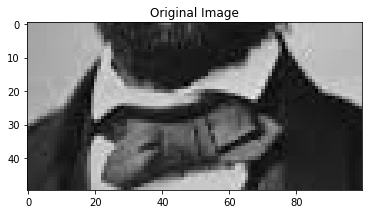

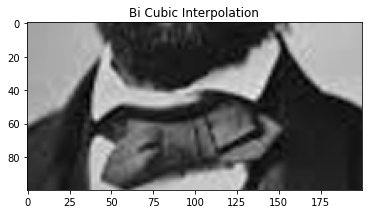

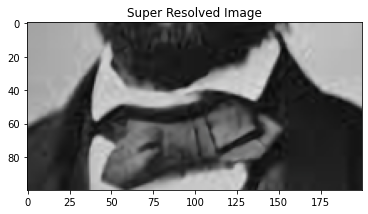

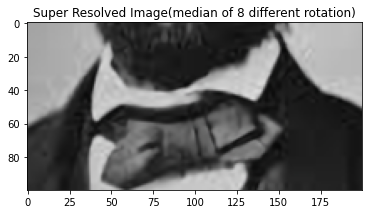

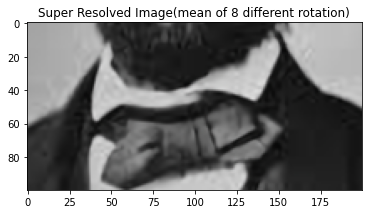

36.98584469915863


In [0]:
a = 120
b = 170
c = 50
d = 150
# from skimage.measure import compare_psnr
from skimage.metrics import peak_signal_noise_ratio as psnr
plt.imshow(cv2.convertScaleAbs(dl.image[a:b,c:d]))
plt.title('Original Image')
plt.show()
plt.figure()
plt.imshow(interpolated_image[a*2:b*2,c*2:d*2])
plt.title('Bi Cubic Interpolation')
plt.show()
plt.figure()
plt.imshow(super_image[a*2:b*2,c*2:d*2])
plt.title('Super Resolved Image')
plt.show()
plt.figure()
plt.imshow(super_image_accumulated_median[a*2:b*2,c*2:d*2])
plt.title('Super Resolved Image(median of 8 different rotation)')
plt.show()
plt.figure()
plt.imshow(super_image_accumulated_avg[a*2:b*2,c*2:d*2])
plt.title('Super Resolved Image(mean of 8 different rotation)')
plt.show()
print(psnr(interpolated_image[a*2:b*2,c*2:d*2], super_image[a*2:b*2,c*2:d*2]))

In [0]:
print(np.max(np.max(dl.image)))
print(np.min(np.min(dl.image)))

233.0
0.0
